In [231]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


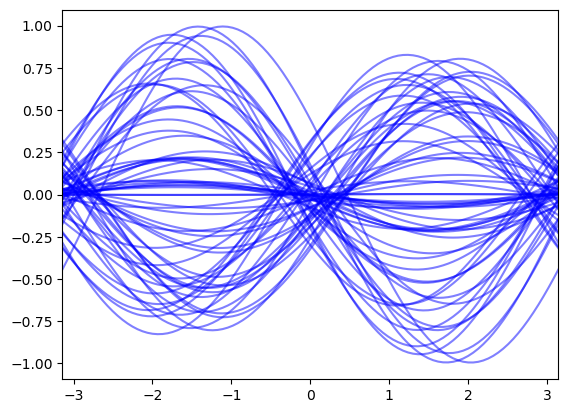

In [232]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [233]:
from np import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

model = NeuralProcess(
                x_size = x_dim,
                y_size = y_dim,
                r_size = r_dim,
                z_size = z_dim,
                h_size_dec = h_dim,
                h_size_enc_lat = h_dim,
                h_size_enc_det = h_dim,
                N_h_layers_dec = 3,
                N_xy_to_si_layers = 2,
                N_sc_to_qz_layers = 1,
                N_h_layers_enc_det = 6,
                use_r = False
                ).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

TypeError: NeuralProcess.__init__() got an unexpected keyword argument 'h_size_lat'

In [204]:
print(model)

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (xy_to_si): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Identity()
    )
    (sc_to_qz): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=100, bias=True)
      (3): Identity()
    )
  )
  (decoder): Decoder(
    (xz_to_py): Sequential(
      (0): Linear(in_features=51, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=2, bias=True)
      (7): Identity()
    )
  )
)


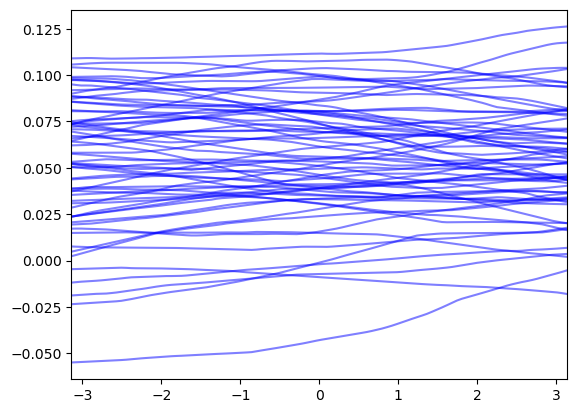

In [205]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    py = model.decoder(x_target.to(device), z_sample.to(device))
    mu = py.mean
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [207]:
from torch.utils.data import DataLoader
from torch.distributions.kl import kl_divergence
from utils import context_target_split
from random import randint

def _loss(p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

batch_size = 2
num_context = 4
num_target = 4
num_context_range=(num_context, num_context)
num_extra_target_range=(num_target, num_target)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.training = True
for epoch in range(30):
    epoch_loss = 0.

    for x, y in data_loader:
        optimizer.zero_grad()

        num_context = randint(*num_context_range)
        num_extra_target = randint(*num_extra_target_range)

        x_context, y_context, x_target, y_target = context_target_split(x, y, num_context, num_extra_target)
        x_context = x_context.to(device); y_context = y_context.to(device)
        x_target = x_target.to(device); y_target = y_target.to(device)

        p_y_pred, q_target, q_context = model(x_context, y_context, x_target, y_target)

        loss = _loss(p_y_pred, y_target, q_target, q_context)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg. Loss = {epoch_loss / len(data_loader)}")



Epoch 1: Avg. Loss = 4.217577029375825
Epoch 2: Avg. Loss = 2.245946162656881
Epoch 3: Avg. Loss = 1.872288177896291
Epoch 4: Avg. Loss = 1.8159448287859559
Epoch 5: Avg. Loss = 1.722375967014581
Epoch 6: Avg. Loss = 1.7226085111796856
Epoch 7: Avg. Loss = 1.667259476657957
Epoch 8: Avg. Loss = 1.6861437426880002
Epoch 9: Avg. Loss = 1.6111568499468267
Epoch 10: Avg. Loss = 1.5784540428780018
Epoch 11: Avg. Loss = -1.2912101364992559
Epoch 12: Avg. Loss = -3.9351682312712075
Epoch 13: Avg. Loss = -4.578715179346502
Epoch 14: Avg. Loss = -4.775446927279234
Epoch 15: Avg. Loss = -5.02365420871973
Epoch 16: Avg. Loss = -5.2182396379970015
Epoch 17: Avg. Loss = -5.375049352928996
Epoch 18: Avg. Loss = -5.402647899180651
Epoch 19: Avg. Loss = -5.392989324480295
Epoch 20: Avg. Loss = -5.496950176730752
Epoch 21: Avg. Loss = -5.678284912467003
Epoch 22: Avg. Loss = -5.724063352286816
Epoch 23: Avg. Loss = -5.829100083962083
Epoch 24: Avg. Loss = -5.98960336971283
Epoch 25: Avg. Loss = -5.9805

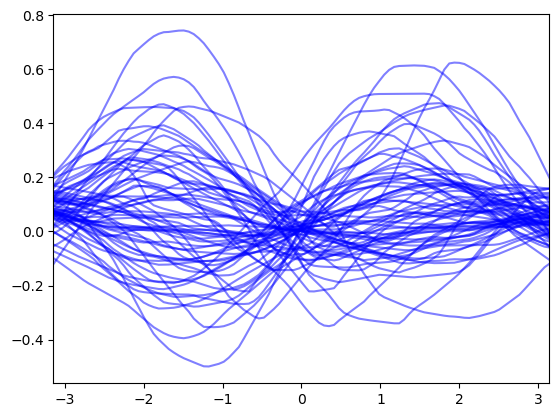

In [208]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    #xz = torch.cat((x_context, z_context), dim=2).to(device).float()
    py = model.decoder(x_target.to(device), z_sample.to(device))

    mu = py.mean
    plt.plot(x_target.cpu().numpy()[0], mu.detach().cpu().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

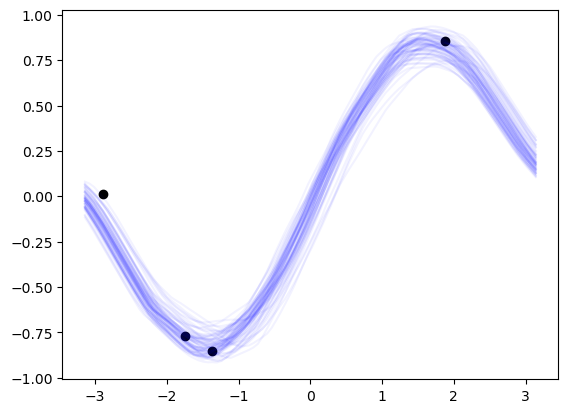

In [228]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

x_context = x_context.to(device)
y_context = y_context.to(device)
x_target = x_target.to(device)

model.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = model(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], 
                alpha=0.05, c='b')

plt.scatter(x_context[0].cpu().numpy(), y_context[0].cpu().numpy(), c='k')
plt.show()